In [1]:
import networkx as nx

import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import network_utilities as nu
import random

import networkx.algorithms.community as nx_comm

# some basic settings for plotting figures
%matplotlib inline 
font = {'family' : 'serif',
        'weight' : 'light',
        'size'   : 20}

plt.rc('font', **font)

# The protein of interest
this_protein = 'YCR072C';
removing_ess = False;

In [2]:
# we read the provided 'essential protein' list. Should we be removing these now? TODO

import csv

# This is the variable that will store the protein names. 
ess_list = []; 

with open('essential_proteins.csv', newline='') as ess_file:
    reader = csv.reader(ess_file)
    ess_data = list(reader)

for i in range(len(ess_data)):
    ess_list.append(ess_data[i][1])

ess_list_clipped = ess_list
ess_list_clipped.remove(this_protein);
#ess_list_prefixed = ["4932." + p for p in ess_list];
#print(ess_list);

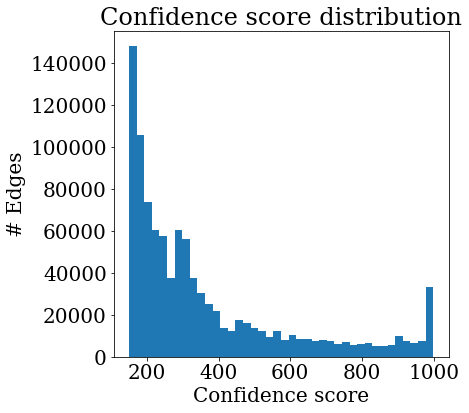

0 nodes removed as essential


In [3]:
# Read in the string-db for Yeast
G0 = nx.read_weighted_edgelist("./yeast_protein_edgelist_trimmed.txt",comments="#",nodetype=str)

# For interest, plot the distribution of confidence scores
plt.figure(figsize=(6,6));
full_edges = G0.edges()
these_weights = [G0[u][v]['weight'] for u,v in full_edges]

plt.hist(these_weights, bins=40);
plt.title("Confidence score distribution")
plt.xlabel("Confidence score")
plt.ylabel("# Edges")
plt.show();

raw_n_nodes = len(G0.nodes)

if (removing_ess):
    G0.remove_nodes_from(ess_list)

print(raw_n_nodes - len(G0.nodes), "nodes removed as essential")
    
# delete those edges with a combined score of <= threshold_score (small confidence)
threshold_score = 700;
for edge in G0.edges: 
    weight = list(G0.get_edge_data(edge[0],edge[1]).values())
    if(weight[0] <= threshold_score):
        G0.remove_edge(edge[0],edge[1])
        
# Take only the largest connected subgraph
largest_cc = max(nx.connected_components(G0),key=len)
G = G0.subgraph(largest_cc);


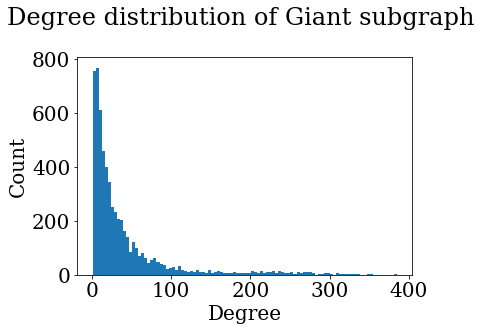

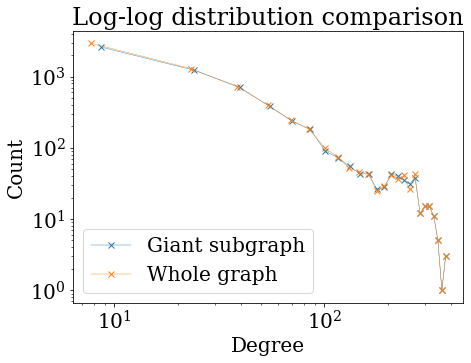

In [4]:
#Let's also examine the degree distribution:

G_degrees = [];
for node in G.degree:
    G_degrees.append(node[1]);
plt.hist(G_degrees, bins=100);
plt.title("Degree distribution of Giant subgraph \n")
plt.xlabel("Degree")
plt.ylabel("Count")
plt.show();

G0_degrees = [];
for node in G0.degree:
    G0_degrees.append(node[1]);
# For comparison with some scale free data, see: 
#scale_free_data = [np.random.power(0.5) for _ in range(0, 5000000)]#000
#degrees = scale_free_data;

plt.figure(figsize=(7,5))

nbins = 25;
bins_count = np.zeros(nbins);
min_deg = min(G_degrees);
max_deg = max(G_degrees);
bin_diff = (max_deg-min_deg)/nbins
centers = np.linspace(min_deg+bin_diff/2,max_deg-bin_diff/2,nbins); # the boundaries of the bins
for deg in G_degrees:
    index_of_bin = int(np.floor((deg-min_deg)/bin_diff));
    if (index_of_bin == nbins): index_of_bin = nbins - 1; # to handle the right edge
    bins_count[index_of_bin] += 1;

plt.loglog(centers,bins_count, linewidth=0.4, marker="x");

# I reuse some variable names here... sorry

bins_count0 = np.zeros(nbins);
min_deg = min(G0_degrees);
max_deg = max(G0_degrees);
bin_diff = (max_deg-min_deg)/nbins
centers0 = np.linspace(min_deg+bin_diff/2,max_deg-bin_diff/2,nbins); # the boundaries of the bins
for deg in G0_degrees:
    index_of_bin = int(np.floor((deg-min_deg)/bin_diff));
    if (index_of_bin == nbins): index_of_bin = nbins - 1; # to handle the right edge
    bins_count0[index_of_bin] += 1;

plt.loglog(centers0,bins_count0, linewidth=0.4, marker="x");
plt.title("Log-log distribution comparison")
plt.legend(["Giant subgraph","Whole graph"])

plt.xlabel("Degree");
plt.ylabel("Count");
plt.show()

In [5]:
# Run the Louvain community finding algorithm on the giant subgraph
communities = nx_comm.louvain_communities(G)
print("We have found", len(communities), "communities")
for i in range(len(communities)):
    print(i,": has",len(communities[i]), "nodes");

We have found 16 communities
0 : has 348 nodes
1 : has 534 nodes
2 : has 840 nodes
3 : has 1172 nodes
4 : has 201 nodes
5 : has 970 nodes
6 : has 11 nodes
7 : has 77 nodes
8 : has 128 nodes
9 : has 91 nodes
10 : has 358 nodes
11 : has 230 nodes
12 : has 20 nodes
13 : has 223 nodes
14 : has 385 nodes
15 : has 344 nodes


In [6]:
# The community containing the protein of interest
protein_comm = {'',};

# Search for the community containing the protein of interest
for c in range(len(communities)):
    if (this_protein in communities[c]): 
        print(this_protein, "is in community c =", c)
        #print("which consists of:", communities[c])
        #print()
        protein_comm = communities[c];

YCR072C is in community c = 14


Graph with 385 nodes and 17691 edges
protein  YCR072C is at index 287
Distances range from  0 to 4


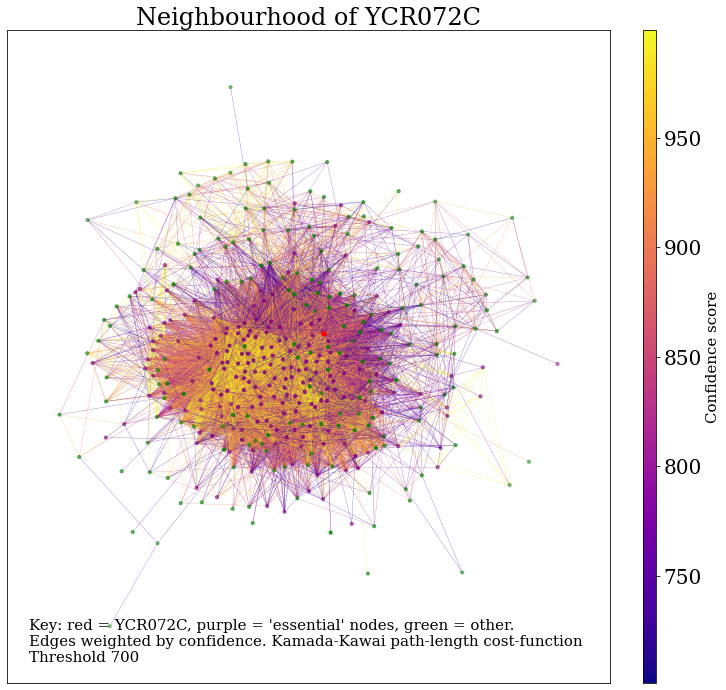

In [7]:
# Moved cutdown_network(...) to network_utilities.py   
# Moved my_draw(...) to network_utilities.py   

# Take the network of just the community of the protein of interest
protein_comm_network = nu.cutdown_network(G, protein_comm)

print(protein_comm_network)

# ------------------------------------------------------------------------------------------------------------ #
# NODE COLORING!                                                                                               #
# This is some looping to make the pretty colors for the nodes. I wish this could be modulised better... TODO! #
# ------------------------------------------------------------------------------------------------------------ #
index_of_protein = list(protein_comm_network.nodes).index(this_protein);
print('protein ', this_protein, 'is at index', index_of_protein);
num_nodes = len(protein_comm_network.nodes);
this_node_list = list(protein_comm_network.nodes);

my_colors = [];
my_sizes = [];
my_alpha = [];
for i in range(num_nodes):
    my_colors.append('g');
    my_sizes.append(10);
    my_alpha.append(0.8);
    
for protein in ess_list:
    if (protein in this_node_list):
        j = this_node_list.index(protein);
        #print("Found essential protein", protein, "at index", j)
        my_colors[j] = 'purple';
        my_sizes[j] = 10;
        my_alpha[j] = 0.8;

# in particular, the following code can fade out more distant nodes (by path length).
alpha_by_distance = True;
# alternatively, highlight a particular shortest path length in yellow
highlight_dist = None;
        
path_lens = [];    
for i in range(num_nodes):
    path_len = nx.shortest_path_length(protein_comm_network, source=this_node_list[i], target=this_protein);
    path_lens.append(path_len);
    if (path_len == 0): continue; # just skip the case where we pick the target node itself
    if (alpha_by_distance): my_alpha[i] *= 1/path_len**0.5
    # highlight by shortest path length:
    if (highlight_dist is not None): 
        if (path_len == highlight_dist): my_colors[i] = 'yellow'

    
print("Distances range from ", min(path_lens), "to", max(path_lens))

# Highlight the protein of interest
my_colors[index_of_protein] = 'r';
my_sizes[index_of_protein] = 20;
my_alpha[index_of_protein] = 1;

# The draw function can be a simple as:
# nu.my_draw(protein_comm_network)

# Draw the network
nu.my_draw(protein_comm_network, kkl=True, node_color=my_colors, node_size=my_sizes, alpha=my_alpha, 
        key_text="Key: red = "+this_protein+", purple = 'essential' nodes, green = other. "+
        "\nEdges weighted by confidence. Kamada-Kawai path-length cost-function \nThreshold "+str(threshold_score), 
        title_text="Neighbourhood of "+this_protein, with_labels=False);

In [8]:
# We need to somehow incorporate the 'essential' protein list.
# Georg seems to suggest purging them entirely (which we probably should do prior to community finding)
# however, we have a problem: the protein of interest is in essential protein list itself. 
print("Is", this_protein, "in the essential protein list:",this_protein in ess_list)

Is YCR072C in the essential protein list: False


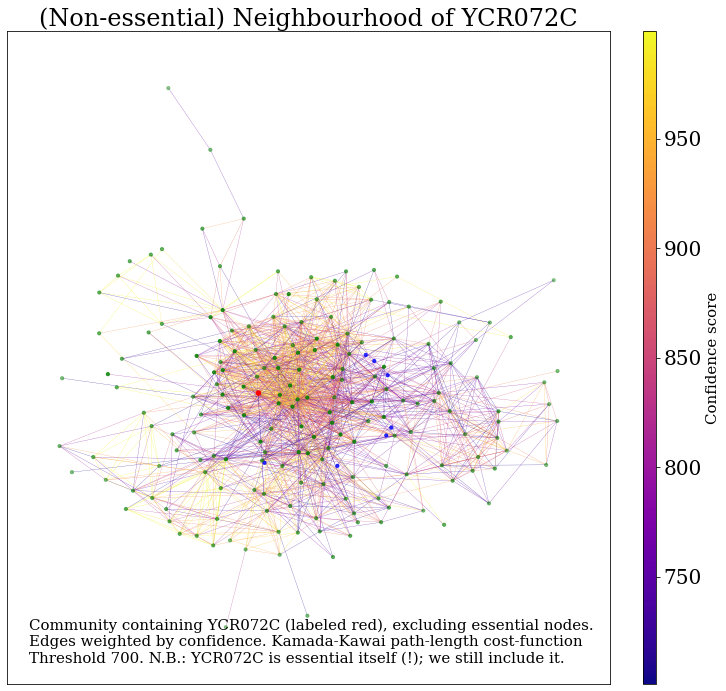

In [9]:
# WIP: please disregard.

# Let's try removing the essential nodes and plotting again:
non_ess_comm_network = protein_comm_network.copy();

# (just reiterating:)
this_node_list = list(protein_comm_network.nodes);

trimmed_ess_list = [p for p in ess_list if p != this_protein]

for ess_prot in trimmed_ess_list:
    if (ess_prot in this_node_list):
        non_ess_comm_network.remove_node(ess_prot)

non_ess_index_of_protein = list(non_ess_comm_network.nodes).index(this_protein);

my_colors = [];
my_sizes = [];
my_alpha = [];

non_ess_node_list = list(non_ess_comm_network.nodes);

for i in range(len(non_ess_node_list)):
    my_colors.append('g');
    my_sizes.append(10);
    my_alpha.append(0.8);

alpha_by_distance = True;
highlight_dist = None;
        
path_lens = [];    
for i in range(len(non_ess_node_list)):
    try: 
        path_len = nx.shortest_path_length(non_ess_comm_network, source=non_ess_node_list[i], target=this_protein);
    except:
        my_colors[i] = 'blue'
        # to handle disconnect pieces. Should probably renetwork on cut-down graph?
    else:
        path_lens.append(path_len);
        if (path_len == 0): continue; # just skip the case where we pick the target node itself
        my_alpha[i] *= 1/path_len**0.5
        # highlight by shortest path length distance:
        if (highlight_dist is not None): 
            if (path_len == highlight_dist): my_colors[i] = 'yellow'    
    
my_colors[non_ess_index_of_protein] = 'r';
my_sizes[non_ess_index_of_protein] = 20;
my_alpha[non_ess_index_of_protein] = 1;

nu.my_draw(non_ess_comm_network, kkl=True, node_color=my_colors, node_size=my_sizes, alpha=my_alpha, 
        key_text="Community containing "+this_protein + " (labeled red), excluding essential nodes. "
        "\nEdges weighted by confidence. Kamada-Kawai path-length cost-function \nThreshold "+str(threshold_score)
        + ". N.B.: "+this_protein+" is essential itself (!); we still include it.", 
        title_text="(Non-essential) Neighbourhood of "+this_protein);

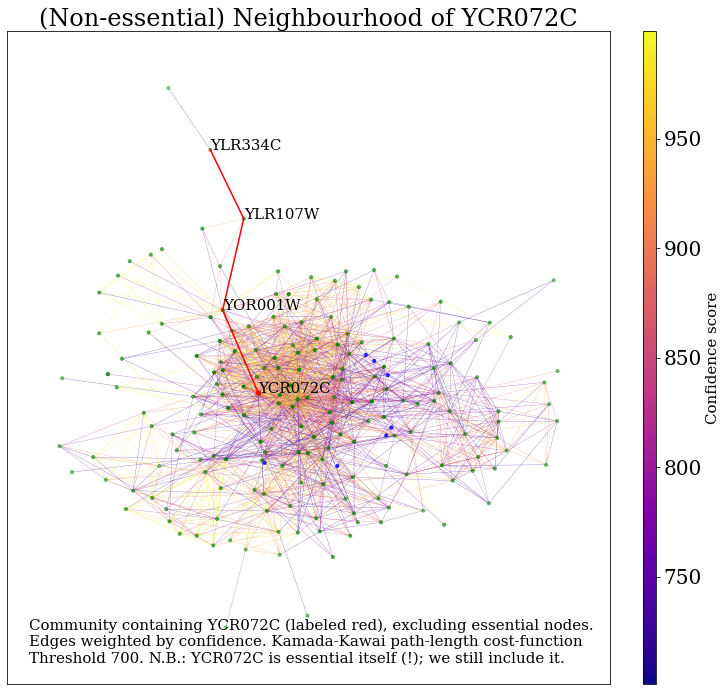

In [10]:
# Lets try plotting a random geodesic for practice. 

def get_shortest_paths(graph, source, target): # useless fn for testing stuff
    return list(nx.all_shortest_paths(graph, source, target));

source = random.choice(list(non_ess_comm_network.nodes))
target = this_protein;

the_paths = get_shortest_paths(non_ess_comm_network,source,target);
geodesic_path = the_paths[0]
    
this_layout = nu.my_draw(non_ess_comm_network, kkl=True, node_color=my_colors, node_size=my_sizes, alpha=my_alpha, 
        key_text="Community containing "+this_protein + " (labeled red), excluding essential nodes. "
        "\nEdges weighted by confidence. Kamada-Kawai path-length cost-function \nThreshold "+str(threshold_score)
        + ". N.B.: "+this_protein+" is essential itself (!); we still include it.", 
        title_text="(Non-essential) Neighbourhood of "+this_protein, 
        delay_show=True);
nu.draw_path_from_nodes(pos=this_layout, node_list=geodesic_path, fontsize=15)
plt.show();